## Vehicle Detection Project

## 1. Read in Images of Cars and Non-Cars

In [1]:
import glob
import os

# Store the cars base directory
cars_basedir= 'vehicles/'

# Store subfolders for the cars image directory
cars_subFolders = os.listdir(cars_basedir)

# create empty list of car images
cars = []

for subFolder in cars_subFolders:
    cars.extend(glob.glob(cars_basedir+subFolder+'/*'))
    
print('Number of Car images found:', len(cars))
    
    
# Store the non-cars base directory
non_cars_basedir= 'non-vehicles/'

# Store subfolders for the cars image directory
non_cars_subFolders = os.listdir(non_cars_basedir)

# create empty list of car images
non_cars = []

for subFolder in non_cars_subFolders:
    non_cars.extend(glob.glob(non_cars_basedir+subFolder+'/*'))
    
print('Number of Non-Car images found:', len(non_cars))


Number of Car images found: 8792
Number of Non-Car images found: 8968


### We can  notice that the number of car images is almost equal to the number of non-car images, and that is important to make our classifier equally biased towards both classes

In [2]:
# Import all needed modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

## 2. Define the functions to be used in the Pipeline

In [3]:
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to return compute color histogram features
def bin_spatial(img, size=(32,32)):
    #c1 = cv2.resize(img[:,:,0], size).ravel()
    #c2 = cv2.resize(img[:,:,1], size).ravel()
    #c3 = cv2.resize(img[:,:,2], size).ravel()
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the each color channel separately
    colorChannel1_hist = np.histogram(img[:,:,0], bins=nbins)
    colorChannel2_hist = np.histogram(img[:,:,1], bins=nbins)
    colorChannel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((colorChannel1_hist[0], colorChannel2_hist[0], colorChannel3_hist[0]))
    # Return the feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2,
                        hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_file_name in imgs:
        img_file_features = []
        # Read in each one by one
        img = mpimg.imread(img_file_name)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            sp_features = bin_spatial(feature_image, size=spatial_size)
            # append to image file features
            img_file_features.append(sp_features)
        
        if hist_feat == True:
            # Apply color_hist() to get color histogram features
            colorHist_features = color_hist(feature_image, hist_bins)
            # Append the new feature vector to the features list
            img_file_features.append(colorHist_features)
        
        if hog_feat == True:
            #check if hog_channel selected is All
            
            if hog_channel == 'ALL':
                hog_features = []
                for colorChannel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,colorChannel],orient, 
                                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],orient, 
                                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_file_features.append(hog_features)
        
        features.append(np.concatenate(img_file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    x_pixels_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_pixels_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((x_span-nx_buffer)/x_pixels_step)
    ny_windows = np.int((y_span-ny_buffer)/y_pixels_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*x_pixels_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*y_pixels_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list

# Define a function that draws bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        #8) Append features to list
        img_features.append(hog_features)

    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        #9) Return concatenated array of features    
        return np.concatenate(img_features)


# Define a function that plots multiple images as a grid
def gridImages(figure,rows,cols,images,titles):
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        image_dims = len(img.shape)
        if image_dims < 3:
            plt.imshow(img, cmap ='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

# Define a function that converts the colors of an image            
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)            

## 3. Test Defined Functions

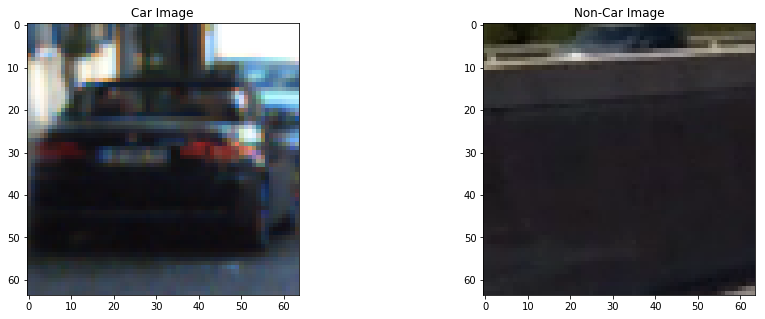

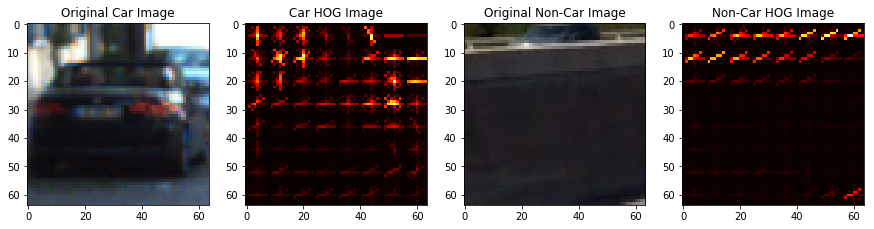

In [4]:
# Choose random non-car and car images
car_index = np.random.randint(0, len(cars))
non_car_index = np.random.randint(0, len(non_cars))

# Read those images
car_image = mpimg.imread(cars[car_index])
non_car_image = mpimg.imread(non_cars[non_car_index])

# Select features to capture
spatial_feature = True
hist_feature = True
hog_feature = True

# Define feature parameters
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
vis = True

# Extract features for the car and non-car image and plot them
car_features, car_hog_image = single_img_features(car_image, color_space, spatial_size,
                                                    hist_bins, orient, pix_per_cell, 
                                                    cell_per_block, hog_channel,
                                                    spatial_feature, hist_feature, hog_feature, vis)

non_car_features, non_car_hog_image = single_img_features(non_car_image, color_space, spatial_size,
                                                    hist_bins, orient, pix_per_cell, 
                                                    cell_per_block, hog_channel,
                                                    spatial_feature, hist_feature, hog_feature, vis)

image_list = [car_image, non_car_image]
image_title_list = ["Car Image","Non-Car Image"]
fig = plt.figure(figsize=(15,5))
gridImages(fig,1,2,image_list,image_title_list)

image_list = [car_image, car_hog_image, non_car_image, non_car_hog_image]
image_title_list = ["Original Car Image", "Car HOG Image", "Original Non-Car Image", "Non-Car HOG Image"]
fig = plt.figure(figsize=(15,5))
gridImages(fig,1,4,image_list,image_title_list)


## 4. Training a Linear Classifier to Classify Cars and Non-Cars

In [ ]:
# Select features to capture
spatial_feature = True
hist_feature = True
hog_feature = True

# Define feature parameters
color_space = 'YCrCb' # Options: RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32

# Define number of random samples to train classifier on and get their indexes
n_random_samples = 1000
random_indexes = np.random.randint(0,len(cars),n_random_samples)

# Extract the random cars and non-cars images
random_cars = cars#np.array(cars)[random_indexes]
random_non_cars = non_cars#np.array(non_cars)[random_indexes]

# Extract car and non-car features for the randomly selected images
car_features = extract_features(random_cars, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_feature, hist_feature, hog_feature)

non_car_features = extract_features(random_non_cars, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_feature, hist_feature, hog_feature)


# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)


print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



In [ ]:
# save classifier
joblib.dump(svc, 'classifier.pkl') 
print('Classifier Saved!')
joblib.dump(X_scaler, 'scaler.pkl') 
print('Scaler Saved!')

## 4. Testing the Classifier

Number of windows:  372 , Time per image:  1.64736008644104
Number of windows:  372 , Time per image:  1.6416816711425781
Number of windows:  372 , Time per image:  1.5689096450805664
Number of windows:  372 , Time per image:  1.6072885990142822
Number of windows:  372 , Time per image:  1.5806257724761963
Number of windows:  372 , Time per image:  1.576702356338501


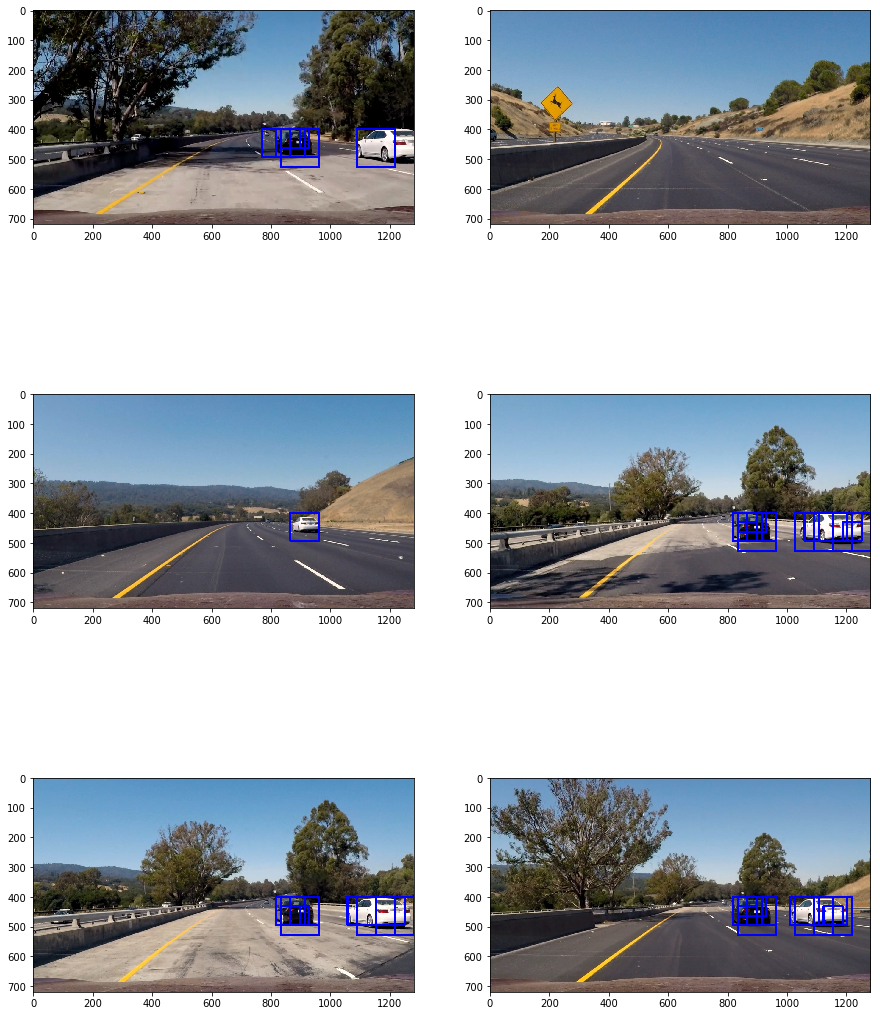

In [5]:
# Load the classifier from pickle file
svc = joblib.load('classifier.pkl') 
X_scaler = joblib.load('scaler.pkl') 
# Store the test images directory
test_images_basedir= 'test_images/'

# Store subfolders for the cars image directory
test_images = os.listdir(test_images_basedir)


# Select features to capture
spatial_feature = True
hist_feature = True
hog_feature = True

# Define feature parameters
color_space = 'YCrCb' # Options: RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32


# define window parameters
y_start_stop = [400,650]
overlap = 0.5
xy_window1 = (64,64)
xy_window2 = (96,96)
xy_window3 = (128,128)


output_images = []
titles = []

for img_name in test_images:
    t1=time.time()
    img = mpimg.imread(test_images_basedir+img_name)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    
    #windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #               xy_window=(64, 96), xy_overlap=(overlap, overlap))
    
    windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                   xy_window=xy_window1, xy_overlap=(overlap, overlap))
    
    
    windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                   xy_window=xy_window2, xy_overlap=(overlap, overlap))
    
    
    windows3 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                   xy_window=xy_window3, xy_overlap=(overlap, overlap))
    
    hot_windows1 = search_windows(img, windows1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature, hog_feat=hog_feature)                       

    hot_windows2 = search_windows(img, windows2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature, hog_feat=hog_feature)                       
    
    hot_windows3 = search_windows(img, windows3, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature, hog_feat=hog_feature)                       


    window_img = draw_boxes(draw_image, hot_windows1, color=(0, 0, 255), thick=6)                    
    window_img = draw_boxes(window_img, hot_windows2, color=(0, 0, 255), thick=6)
    window_img = draw_boxes(window_img, hot_windows3, color=(0, 0, 255), thick=6)    

    output_images.append(window_img)
    titles.append("")
    
    print("Number of windows: ", len(windows1)+len(windows2)+len(windows3), ", Time per image: ", time.time()-t1)



fig = plt.figure(figsize=(15,20))
gridImages(fig,3,2,output_images,titles)

## 4. Hog Sub-Sample Efficient Method

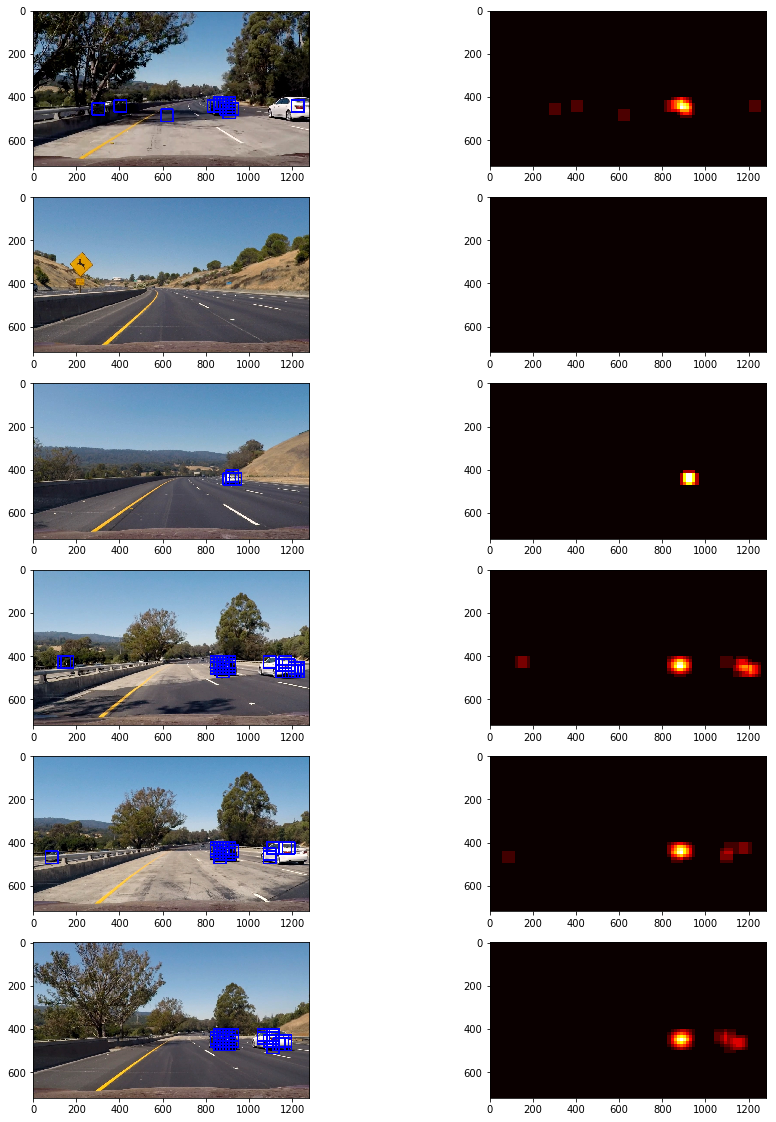

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # Initialize a heatmap with zeros
    heatmap = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    return draw_img, heatmap

ystart = 400
ystop = 656
scale = 0.9
    
output_images = []
titles = []

for img_name in test_images:
    img = mpimg.imread(test_images_basedir+img_name)
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    output_images.append(out_img)
    output_images.append(heatmap)
    titles.append("")
    titles.append("")

fig = plt.figure(figsize=(15,20))
gridImages(fig,6,2,output_images,titles)

## 5. Unifying Multiple Detections and Removing False Positives

In [7]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

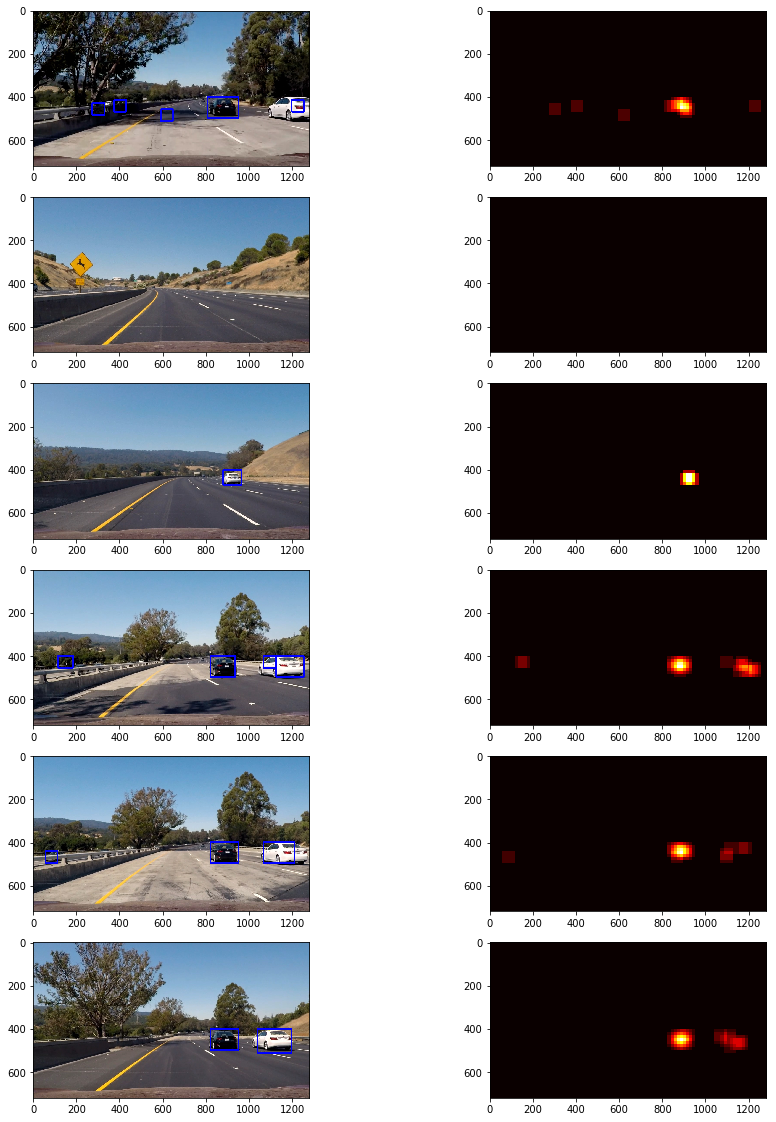

In [8]:
output_images = []
titles = []

for img_name in test_images:
    img = mpimg.imread(test_images_basedir+img_name)
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    output_images.append(draw_img)
    output_images.append(heatmap)
    titles.append("")
    titles.append("")

fig = plt.figure(figsize=(15,20))
gridImages(fig,6,2,output_images,titles)

## 6. Testing on the Video

In [ ]:
heatmap_threshold = 1
# Define a function that processes each frame
def process_image(img):
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heatmap = apply_threshold(heatmap,heatmap_threshold)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

## 7. Creating an Object to Store Previous Frames and Use them to Remove False Positives

In [ ]:
# Define FindCars Object
class FindCars:
    def __init__(self,scales,ystart,ystop,max_num_frames,heatmap_threshold,color_space):
        self.scales = scales
        self.ystart = ystart
        self.ystop = ystop
        self.max_num_frames = max_num_frames
        self.heatmap_threshold = heatmap_threshold
        self.cspace = color_space
        self.bbox_lists = []
        self.num_bbox_lists = 0
    
    def process_image(self, img):
        # Initialize a heatmap with zeros
        heatmap = np.zeros_like(img[:,:,0])
        
        
        image_bboxes = []
        
        '''
        for scale in self.scales:
            bboxes = self.findCars(img, self.ystart, self.ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, self.cspace)
            for box in bboxes:
                image_bboxes.append(box)
        '''
        for i in range(len(scales)):
            bboxes = self.findCars(img, self.ystart[i], self.ystop[i], self.scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, self.cspace)
            for box in bboxes:
                image_bboxes.append(box)         
         
                
        if(self.num_bbox_lists < max_num_frames):
            self.bbox_lists.append(image_bboxes)
            self.num_bbox_lists += 1
        else:
            self.bbox_lists = self.bbox_lists[1:]
            self.bbox_lists.append(image_bboxes)
            
        for bbox_list in self.bbox_lists:
            heatmap = add_heat(heatmap, bbox_list)
            
        heatmap = apply_threshold(heatmap,self.heatmap_threshold)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        return draw_img            
        
        
    def findCars(self, img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace):

        #draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv=self.cspace)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        bbox_list = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                    bbox_list.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
        return bbox_list


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Select features to capture
spatial_feature = True
hist_feature = True
hog_feature = True

# Define feature parameters
color_space = 'RGB2YCrCb' # Options: RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
#ystart = 400
ystart = [350,400,400]
#ystop = 650
ystop = [500,650,650]
#scales = [1,1.5]
scales = [0.95,1,1.5]
max_num_frames = 10
#heatmap_threshold = 15
heatmap_threshold = 35

#vid_output = './project_clip_video_output.mp4'
#clip1 = VideoFileClip("./project_video.mp4").subclip(23,31)
#clip1 = VideoFileClip("./project_video.mp4").subclip(36,43)
vid_output = './lane_and_vehicle_detection.mp4'
clip1 = VideoFileClip("./lane_detection.mp4")
my_object = FindCars(scales,ystart,ystop,max_num_frames,heatmap_threshold,color_space)
vid_clip = clip1.fl_image(my_object.process_image)
%time vid_clip.write_videofile(vid_output, audio=False)